# **Statistics lecture 4 Hands-on session : solutions notebook**

This is the companion notebook to lecture 4 in the statistical course series, covering the following topics:
1. Parameter estimation using simple tools
2. Parameter estimation using the profile likelihood
3. Limit-setting, using simple tools
4. Limit-setting using the profile likelihood

First perform the usual imports:

In [4]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

## 1. Parameter estimation using simple techniques

In the previous lecture, we have applied hypothesis testing to a simple counting experiment, using the observed count $n$ as discriminant.
Recall the example we used:

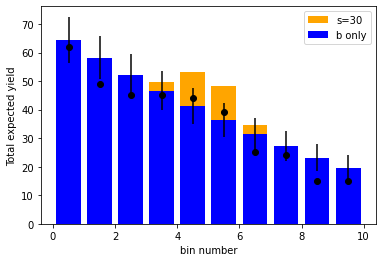

In [5]:
nbins = 10
x = np.linspace(0.5, nbins - 0.5, nbins)
# The background follows a linear shape
b_yields = np.array([ (1 - i/2/nbins) for i in range(0, nbins) ])
b_yields *= b_yields/np.sum(b_yields)
# The signal shape is a peak
s_yields = np.zeros(nbins)
s_yields[3:7] = [ 0.1, 0.4, 0.4, 0.1 ]
# Now generate some data
s = 10
b = 500
s_and_b = s*s_yields + b*b_yields
b_only = b*b_yields
np.random.seed(1) # make sure we always generate the same
data = [ np.random.poisson(s*s_yield + b*b_yield) for s_yield, b_yield in zip(s_yields, b_yields) ]
s30_and_b = 30*s_yields + b*b_yields
plt.bar(x, s30_and_b, color='orange', label='s=30')
plt.bar(x, b_only, color='b', yerr=np.sqrt(b_only), label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend()

There are some fluctuations in the data, but it seems that the $s$ is fairly small, probably smaller than the $s=30$ shown in orange. We can use the tools defined in the previous lecture to find the best-fit $s$:

In [3]:
def lambda_s(s_hypo, data) :
    return -2*sum( [ np.log(scipy.stats.poisson.pmf(n, s_hypo*s_yield + b*b_yield)) for n, s_yield, b_yield in zip(data, s_yields, b_yields) ] )

def lambda_s_data(s_hypo) :
    return lambda_s(s_hypo, data)

from scipy.optimize import minimize_scalar

In [4]:
s_hat = minimize_scalar(lambda_s_data, (0, 100)).x
print(s_hat)

3.523759577550049


So it's indeed pretty small. However we usually want to also have an uncertainty to go with the central value -- this allows for instance to estimate compatibility with a value such as $s=0$ or $s=30$.

We'll see how to do this properly in the next section, but for now we'll try to do this in a simple way.

For this, only consider a measurement in one bin, and assume it is Gaussian:

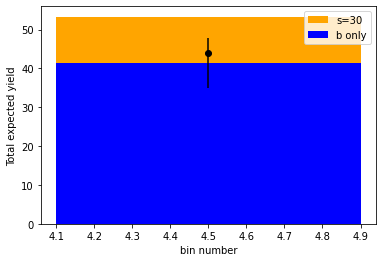

In [32]:
sb4 = s30_and_b[4]
b4 = b_only[4]
n4 = data[4]
plt.bar(x[4], sb4, color='orange', label='s=30')
plt.bar(x[4], b4, color='b', yerr=np.sqrt(b_only[4]), label='b only')
plt.scatter(x[4], n4, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend()

In this simple model, the best-fit value is

In [6]:
s4 = n4 - b4
print(s4)

2.70967741935484


And more importantly, we know that the uncertainty on this value is

In [7]:
sigma4 = np.sqrt(n4)
print(sigma4)

6.6332495807108


So we have our result: $s_4 = 2.7 \pm 6.6$.

One thing to understand about this result: it does not mean the true value is necessarily between $2.7 - 6.6$ and $2.7 + 6.6$. The interval is to be taken in the sense of a Gaussian distribution: there is a $68\%$ chance that the true value is indeed somewhere in this interval, but it can also fall outside.

Text(46, 0.08, 's4+b4 = 44')

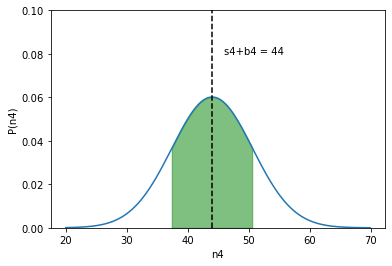

In [8]:
ns = np.arange(20,70,0.1)
plt.plot(ns, scipy.stats.norm.pdf(ns, loc=n4, scale=sigma4))
plt.ylim(0,0.1)
plt.xlabel('n4')
plt.ylabel('P(n4)')

up = 1
shaded_ns = np.arange(n4 - sigma4, n4 + sigma4, 0.1)
plt.fill_between(shaded_ns, scipy.stats.norm.pdf(shaded_ns, loc=n4, scale=sigma4), alpha=0.5, color='g')
plt.axvline(x=n4, linestyle='--', color='k')
plt.text(n4 + 2, 0.08, 's4+b4 = %g' % (s4+b4))

The graph above represents the probability to draw a random value of $n_4$, for a given value of $s_4+b_4$, but one can make a similar statement for $s_4 + b_4$ once $n_4$ is known:

*For a given measuremed value $n_4$, there is a 68% probability that the true $s_4$ is within $n_4 - b_4 \pm \sqrt{n_4}$*.

## 2. Parameter estimation using likelihood methods

The above method is only applicable to single-bin measurements, so we need something better for our multi-bin case.

To test some value $s$, we use the likelihood-based discriminant
$$
t(s) = -2 \log \frac{L(s)}{L(\hat{s})}
$$
following the same principle as for discovery. Define it:

In [9]:
def t_s(s_test) :
    return lambda_s(s_test, data) - lambda_s(s_hat, data)


Now plot it:

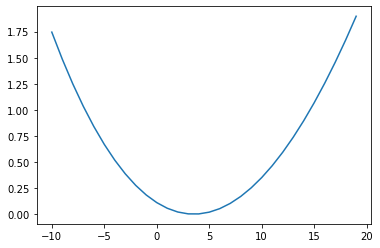

In [10]:
s_vals = np.arange(-10,20,1)
plt.plot(s_vals, t_s(s_vals))

It follows a parabola, which is expected for a near-Gaussian case. A short computation shows that for a Gaussian likelihood $\hat{s} \sim G(s, \sigma_s)$, then
$$
t(s) = \left(\frac{s - \hat{s}}{\sigma_s}\right)^2
$$
and we have a parabola. In this case, the $\pm 1\sigma$ uncertainties are reached for $t(s)=1$. We consider that this still applies to other cases, so that we **define** the uncertainties using the crossings with $t(s)=1$:

14.616612758932273 -6.82979837729991
3.523759577550049 + 11.092853181382225 - 10.35355795484996


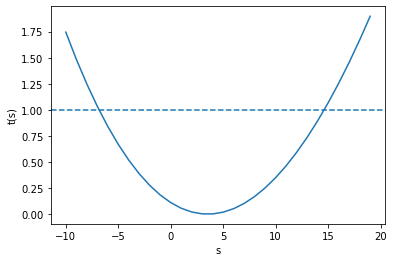

In [11]:
plt.plot(s_vals, t_s(s_vals))
plt.axhline(1, linestyle='--')
plt.xlabel('s')
plt.ylabel('t(s)')
s_pos = scipy.optimize.root_scalar(lambda s : t_s(s) - 1, bracket=(10,20)).root
s_neg = scipy.optimize.root_scalar(lambda s : t_s(s) - 1, bracket=(-10,0)).root
print(s_pos, s_neg)
print (s_hat, '+', s_pos - s_hat, '-', s_hat - s_neg)

## 3.  Limit-setting using simple tools

Measuring the signal is useful when it is large, but when it is very small it can be more interesting to set an upper limit on it. This means computing the value of the signal yield that is large enough to be excluded with a given confidence level, typically 95%.

This "95%" means that if we would repeat the experiment many times, the true signal would be below the limit 95% of the time.  This is also represented in the picture below, with the shaded area corresponding to 5% of the integral.

Text(33, 0.08, 'observed n4')

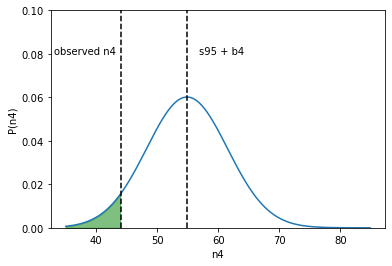

In [12]:
ns = np.arange(35,85,0.1)
plt.plot(ns, scipy.stats.norm.pdf(ns, loc=n4 + 1.64*sigma4, scale=sigma4))
plt.ylim(0,0.1)
plt.xlabel('n4')
plt.ylabel('P(n4)')

up = 1
shaded_ns = np.arange(35, n4, 0.1)
plt.fill_between(shaded_ns, scipy.stats.norm.pdf(shaded_ns, loc=n4 + 1.64*sigma4, scale=sigma4), alpha=0.5, color='g')
plt.axvline(x=n4 + 1.64*sigma4, linestyle='--', color='k')
plt.axvline(x=n4, linestyle='--', color='k')
plt.text(n4 + 1.64*sigma4 + 2, 0.08, 's95 + b4')
plt.text(n4 - 11, 0.08, 'observed n4')

Let's now compute the limit in the single-bin case, using the values of $s_4$, $b_4$ $\sigma_4$ and $n_4$ defined in the previous sections.

In [13]:
# First find the position on the Gaussian corresponding to a 5%  quantile
z_5 = scipy.stats.norm.isf(0.05)
print(z_5)
# and the limit
s95 = n4 + z_5*sigma4 - b4
print('95% CL limit = ', s95)

1.6448536269514729
95% CL limit =  13.620402050661333


## 4. Limit-setting in the general case

Now let's apply limit-setting on the multi-bin example. In fact, the signal in this case is low enough that setting a limit makes sense:

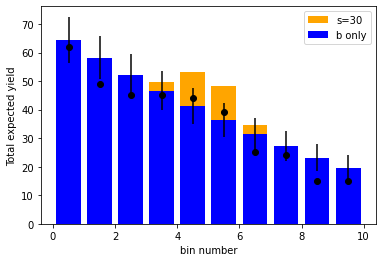

In [14]:
plt.bar(x, s30_and_b, color='orange', label='s=30')
plt.bar(x, b_only, color='b', yerr=np.sqrt(b_only), label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend()

As usual, we use the likelihood-based discriminant
$$
t(s)  = -2 \log \frac{L(s)}{L(\hat{s})}
$$

The only difference compared to parameter measurement is that we will only consider the positive side of the distribution, $s > \hat{s}$, since we are looking for an *upper* limit. 

As we saw before, for the Gaussian case we have
$$
t(s) = \left(\frac{s - \hat{s}}{\sigma_s}\right)^2
$$
so that the limit is reached for $t(s) = 1.64^2$.

Another way to represent it is to note that the p-value is given by $1 - \Phi\left(\sqrt{t(s)}\right)$, still for the Gaussian case. This allows to compute the p-value as a function of $s$. Then to compute the limit, we check when this p-value reaches 5% (for a 95% CL limit)


      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 22.168063096101502

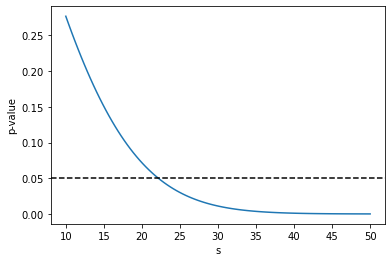

In [15]:
s_vals = np.linspace(10, 50, 100)
plt.plot(s_vals, scipy.stats.norm.sf(np.sqrt(t_s(s_vals))))
plt.xlabel('s')
plt.ylabel('p-value')
plt.axhline(0.05, linestyle='--', color='k')
scipy.optimize.root_scalar(lambda s : scipy.stats.norm.sf(np.sqrt(t_s(s))) - 0.05, bracket=(20,30) )

## 5. Expected limits

One can compute *expected* limits for a given scenario, for instance $\hat{s}=$. This can be obtained using 2 methods:
* By generating "toy datasets" (pseudo-experiments), computing the limit for each one and histogramming the result
* by fitting a special "Asimov" dataset that is constructed to precisely correspond to this hypothesis. For instance here one would build a dataset consisting only of background.

First, we investigate the difference between the two:

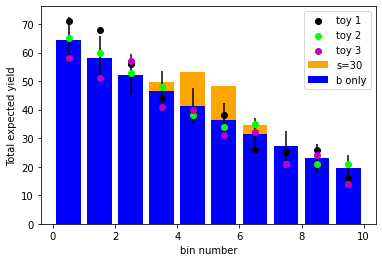

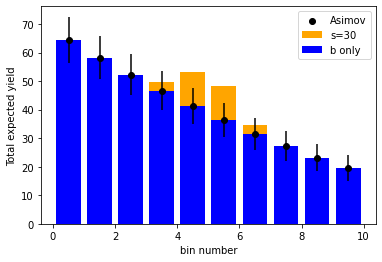

In [10]:
toy_data1 = np.random.poisson(b_only)
toy_data2 = np.random.poisson(b_only)
toy_data3 = np.random.poisson(b_only)
plt.bar(x, s30_and_b, color='orange', label='s=30')
plt.bar(x, b_only, color='b', yerr=np.sqrt(b_only), label='b only')
plt.scatter(x, toy_data1, zorder=10, color='k', label='toy 1')
plt.scatter(x, toy_data2, zorder=10, color='lime', label='toy 2')
plt.scatter(x, toy_data3, zorder=10, color='m', label='toy 3')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend()
plt.figure()
asimov = b_only
plt.bar(x, s30_and_b, color='orange', label='s=30')
plt.bar(x, b_only, color='b', yerr=np.sqrt(b_only), label='b only')
plt.scatter(x, asimov, zorder=10, color='k', label='Asimov')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend()


The toys fluctuate around the b-only expectation, while the Asimov perfectly lines up with it by definition.

To get Asimov-based results, one also includes the range of variations of these limits du to the fluctuations of $\hat{s}$. Since
$$
t(s) = \left(\frac{s - \hat{s}}{\sigma_s}\right)^2
$$
the $\pm 1\sigma$ variations in the limit are given by
$$
\sqrt{t(s)} \to \sqrt{t(s)} \pm 1 \text{ for the } \pm 1\sigma \text{ variation}
$$


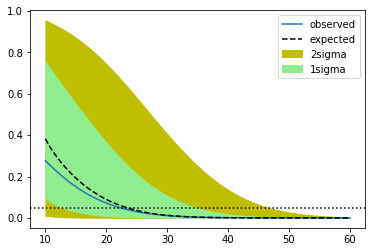

In [18]:
def lambda_gamma_s(s_hypo, data) :
    return -2*sum( [ np.log(scipy.stats.gamma.pdf(n+1, s_hypo*s_yield + b*b_yield)) for n, s_yield, b_yield in zip(data, s_yields, b_yields) ] )

def t_s_asimov(s_test) :
    return lambda_gamma_s(s_test, asimov) - lambda_gamma_s(0, asimov)

s_vals = np.linspace(10, 60, 100)
observed = scipy.stats.norm.sf(np.sqrt(t_s(s_vals)))
expected = scipy.stats.norm.sf(np.sqrt(t_s_asimov(s_vals)))
exp_pos1 = scipy.stats.norm.sf(np.sqrt(t_s_asimov(s_vals)) + 1)
exp_neg1 = scipy.stats.norm.sf(np.sqrt(t_s_asimov(s_vals)) - 1)
exp_pos2 = scipy.stats.norm.sf(np.sqrt(t_s_asimov(s_vals)) + 2)
exp_neg2 = scipy.stats.norm.sf(np.sqrt(t_s_asimov(s_vals)) - 2)
plt.fill_between(s_vals, exp_pos2, exp_neg2, color='y', label='2sigma')
plt.fill_between(s_vals, exp_pos1, exp_neg1, color='lightgreen', label='1sigma')
plt.plot(s_vals, observed, label='observed')
plt.plot(s_vals, expected, color='k', linestyle='--', label='expected')
plt.axhline(0.05, linestyle=':', color='k')
plt.legend()
#plt.fill_between(s_vals, scipy.stats.norm.sf(np.sqrt(t_s_asimov(s_vals)) + 2), scipy.stats.norm.sf(np.sqrt(t_s_asimov(s_vals)) - 2), color='y')

As before, we can find the limit values by looking at the intersection with $p=0.05$

## 6. $CL_s$ limits

We now add one last wrinkle: the $CL_s$ procedure. This is an additional correction on top of the limit setting procedure described above, to avoid the limit going negative. Just to see why this is needed, recall how we set the limit in the 1-bin case:

In [ ]:
print('n4 =', n4, ', b4 =', b4)
s95 = n4 + z_5*sigma4 - b4
print('95% CL limit = ', s95)

Now imagine we had a negative fluctuation in $n_4$, and repeat the computation

In [ ]:
n4 = 30
print('n4 =', n4, ', b4 =', b4)
s95 = n4 + z_5*sigma4 - b4
print('95% CL limit = ', s95)

This requires a pretty large fluctuation, but it can happen. Of course we know that the signal is positive, so we know that this is due to a fluctuation: basically we know we are in those 5% of experiments where the limit isn't valid.

One way to do this is to correct the p-value for $s \sim 0$ to avoid setting an exclusion in this region. This is what $CL_s$ does, by using
$$
p_{CL_s} = \frac{p(s)}{p(s=0)}
$$
as a modified p-value. If there is good exclusion near 0 ($p(0) \ll 1$) then the denominator is small, which inflates $p_{CL_s}$ and makes the exclusion weaker.
We can modify our previous example to do this:

(0.0, 1.0)

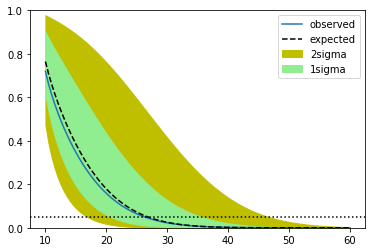

In [31]:
observed_cls = observed / [ scipy.stats.norm.sf(np.sqrt(t_s(s)) - np.sqrt(t_s_asimov(s))) for s in s_vals ]
expected_cls = expected / [ scipy.stats.norm.sf(np.sqrt(t_s_asimov(s)) - np.sqrt(t_s_asimov(s))) for s in s_vals ]
exp_pos1_cls = exp_pos1 / [ scipy.stats.norm.sf(np.sqrt(t_s_asimov(s)) - np.sqrt(t_s_asimov(s)) + 1) for s in s_vals ]
exp_neg1_cls = exp_neg1 / [ scipy.stats.norm.sf(np.sqrt(t_s_asimov(s)) - np.sqrt(t_s_asimov(s)) - 1) for s in s_vals ]
exp_pos2_cls = exp_pos2 / [ scipy.stats.norm.sf(np.sqrt(t_s_asimov(s)) - np.sqrt(t_s_asimov(s)) + 2) for s in s_vals ]
exp_neg2_cls = exp_neg2 / [ scipy.stats.norm.sf(np.sqrt(t_s_asimov(s)) - np.sqrt(t_s_asimov(s)) - 2) for s in s_vals ]
plt.fill_between(s_vals, exp_pos2_cls, exp_neg2_cls, color='y', label='2sigma')
plt.fill_between(s_vals, exp_pos1_cls, exp_neg1_cls, color='lightgreen', label='1sigma')
plt.plot(s_vals, observed_cls, label='observed')
plt.plot(s_vals, expected_cls, color='k', linestyle='--', label='expected')
plt.axhline(0.05, linestyle=':', color='k')
plt.legend()
plt.ylim(0,1)


We see that the exclusion indeed becomes weaker near 0, which is not not excluded anymore by the $2\sigma$ band.